You are about to learn how to use AS and WITH to tidy up your queries and make them easier to read.
## AS

You learned in an earlier tutorial how to use AS to rename the columns generated by your queries, which is also known as aliasing. This is similar to how Python uses as for aliasing when doing imports like import pandas as pd or import seaborn as sns.

To use AS in SQL, insert it right after the column you select. 
## WITH ... AS

On its own, AS is a convenient way to clean up the data returned by your query. It's even more powerful when combined with WITH in what's called a "common table expression".

A common table expression (or CTE) is a temporary table that you return within your query. CTEs are helpful for splitting your queries into readable chunks, and you can write queries against them.

Also, it's important to note that CTEs only exist inside the query where you create them, and you can't reference them in later queries. So, any query that uses a CTE is always broken into two parts: (1) first, we create the CTE, and then (2) we write a query that uses the CTE

In [1]:
import os 
import pandas as pd
from google.cloud import bigquery

C:\Users\Admin\.conda\envs\data_science\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# Set this to the full absolute path of your downloaded key
# Set this to the full absolute path of your downloaded key 
# get the key form google console to be able to access bigquery which is hosted my google
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "E:\\c_extend\\Documents\\egerdrive-7433adb919ad.json"
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/mwaki/Documents/Documents/Credentials/egerdrive-7433adb919ad.json"

## Example: How many Bitcoin transactions are made per month?

We're going to use a CTE to find out how many Bitcoin transactions were made each day for the entire timespan of a bitcoin transaction dataset.

We'll investigate the transactions table. Here is a view of the first few rows

In [3]:
client = bigquery.Client()
dataset_ref = client.dataset('crypto_bitcoin',project='bigquery-public-data')
dataset = client.get_dataset(dataset_ref)
table_ref = dataset_ref.table('transactions')
table = client.get_table(table_ref)

In [4]:
client.list_rows(table,max_results=5).to_dataframe()

,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,275,275,1,0,00000000dc55860c8a29c58d45209318fa9e9dc2c1833a...,181,2009-01-12 06:02:13+00:00,2009-01-01,1,2,4000000000.000000000,4000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'f4184...","[{'index': 0, 'script_asm': '04b5abd412d4341b4..."
1,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,275,275,1,0,0000000054487811fc4ff7a95be738aa5ad9320c394c48...,182,2009-01-12 06:12:16+00:00,2009-01-01,1,2,3000000000.000000000,3000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'a16f3...","[{'index': 0, 'script_asm': '0401518fa1d1e1e3e..."
2,12b5633bad1f9c167d523ad1aa1947b2732a865bf5414e...,276,276,1,0,00000000f46e513f038baf6f2d9a95b2a28d8a6c985bcf...,183,2009-01-12 06:34:22+00:00,2009-01-01,1,2,2900000000.000000000,2900000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '591e9...","[{'index': 0, 'script_asm': '04baa9d3665315562..."
3,828ef3b079f9c23829c56fe86e85b4a69d9e06e5b54ea5...,276,276,1,0,00000000fb5b44edc7a1aa105075564a179d65506e2bd2...,248,2009-01-12 20:04:20+00:00,2009-01-01,1,2,2800000000.000000000,2800000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '12b56...","[{'index': 0, 'script_asm': '04bed827d37474bef..."
4,35288d269cee1941eaebb2ea85e32b42cdb2b04284a56d...,277,277,1,0,00000000689051c09ff2cd091cc4c22c10b965eb8db3ad...,545,2009-01-15 05:48:32+00:00,2009-01-01,1,2,2500000000.000000000,2500000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'd71fd...","[{'index': 0, 'script_asm': '044a656f065871a35..."


Since the block_timestamp column contains the date of each transaction in DATETIME format, we'll convert these into DATE format using the DATE() command.

We do that using a CTE, and then the next part of the query counts the number of transactions for each date and sorts the table so that earlier dates appear first.


In [5]:
query_with_cte ="""
with time as (
             select date(block_timestamp) as trans_date from `bigquery-public-data.crypto_bitcoin.transactions`
             )
             select count(1) as transactions,trans_date from time
             group by trans_date
             order by trans_date
"""


In [6]:
query_job = client.query(query_with_cte)
query_out = query_job.to_dataframe()

C:\Users\Admin\.conda\envs\data_science\Lib\site-packages\google\cloud\bigquery\table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [7]:
query_out.head()

,transactions,trans_date
0,1,2009-01-03
1,14,2009-01-09
2,61,2009-01-10
3,93,2009-01-11
4,101,2009-01-12


Since they're returned sorted, we can easily plot the raw results to show us the number of Bitcoin transactions per day over the whole timespan of this dataset.

<Axes: xlabel='trans_date'>

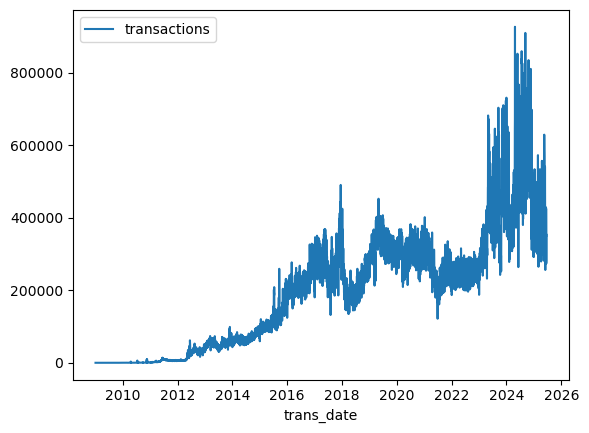

In [8]:
query_out.set_index('trans_date').plot()